In [ ]:
import torch
import os
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils import data
from google.colab import drive
import time
from PIL import Image

drive.mount('/content/drive')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/archive


Mount Google Colab file to Google Drive folder

In [ ]:
os.chdir('drive/MyDrive/archive')
print(os.getcwd())

In [ ]:
train_images = torch.load('train_images32')
train_labels = torch.load('train_labels')

test_images = torch.load('test_images32')
test_labels = torch.load('test_labels')

In [ ]:
print(train_images.shape)

torch.Size([5784, 32, 32])


In [ ]:
train_labels = train_labels.type(torch.LongTensor)
test_labels = test_labels.type(torch.LongTensor)

print(train_labels.shape)

torch.Size([5784])


In [ ]:
train_images = train_images.to(torch.device('cuda'))
train_labels = train_labels.to(torch.device('cuda'))

test_images = test_images.to(device='cuda')
test_labels = test_labels.to(torch.device('cuda'))

print(train_images.size())
train_images.is_cuda

torch.Size([5784, 32, 32])


True

In [ ]:
test_images = test_images.reshape([len(test_images),-1])
print(test_images.shape)

torch.Size([624, 1024])


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class myDataSet(Dataset):
  def __init__(self, images, labels):
    self.data = images
    self.targets = labels

  def __getitem__(self,index):
    return self.data[index], self.targets[index]

  def __len__(self):
    return len(self.targets)

trainDataset = myDataSet(train_images,train_labels)
testDataset = myDataSet(test_images,test_labels)

In [ ]:
X, y = next(iter(DataLoader(trainDataset, batch_size=9, shuffle = True)))
X.shape

torch.Size([9, 1024])

ValueError: ignored

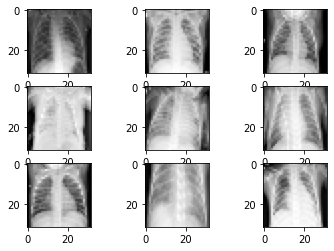

In [ ]:
import matplotlib.pyplot as plt

Q = X.cpu()

for i in range(len(Q)):
  plt.subplot(3,3,i+1)
  plt.imshow(Q[i,:,:], cmap='gray')

In [ ]:
train_iter = DataLoader(trainDataset, batch_size=128, shuffle=True)
test_iter = DataLoader(testDataset, batch_size=128, shuffle=True)

In [ ]:
X,y = next(iter(train_iter))
print(X.shape)

torch.Size([128, 1024])


In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=7, padding=3), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=7, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2)
    nn.Conv2d(16, 64, kernel_size=5, padding=1), nn.ReLU(),

    nn.Flatten(),
    nn.Linear(24576, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 2)
)
net = net.to(device='cuda')

In [ ]:
num_hiddens = 256
num_inputs = 32**2
num_outputs = 2

net = nn.Sequential(
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net = net.to(device='cuda')
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
optimizer0 = torch.optim.SGD(net.parameters(), lr=1e-4)
loss0 = nn.CrossEntropyLoss()

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    acc_sum, n = torch.tensor(0.0, device = device), 0

    with torch.no_grad():
        for X, y in data_iter:
           
            acc_sum += (net(X).argmax(axis=1) == y).sum().item()
            n += y.numel()
    return acc_sum / n

In [ ]:
def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    for X, y in train_iter:
        l = loss0(net(X), y)
        optimizer0.zero_grad()
        l.backward()
        optimizer0.step()
    l = loss0(net(test_images), test_labels)
    test_acc = evaluate_accuracy_gpu(net, test_iter, device='cuda')
    print(f'epoch {epoch + 1}, loss {l:f}, test_acc {test_acc:f}')

epoch 1, loss 0.806258, test_acc 0.625000
epoch 2, loss 0.786375, test_acc 0.625000
epoch 3, loss 0.773159, test_acc 0.625000
epoch 4, loss 0.765484, test_acc 0.625000
epoch 5, loss 0.758852, test_acc 0.625000
epoch 6, loss 0.755943, test_acc 0.625000
epoch 7, loss 0.750430, test_acc 0.623397
epoch 8, loss 0.747176, test_acc 0.623397
epoch 9, loss 0.744607, test_acc 0.623397
epoch 10, loss 0.742995, test_acc 0.623397
epoch 11, loss 0.740065, test_acc 0.623397
epoch 12, loss 0.738446, test_acc 0.623397
epoch 13, loss 0.735952, test_acc 0.623397
epoch 14, loss 0.733783, test_acc 0.623397
epoch 15, loss 0.730859, test_acc 0.623397
epoch 16, loss 0.728408, test_acc 0.623397
epoch 17, loss 0.726344, test_acc 0.623397
epoch 18, loss 0.724046, test_acc 0.623397
epoch 19, loss 0.721552, test_acc 0.623397
epoch 20, loss 0.719868, test_acc 0.623397
epoch 21, loss 0.719349, test_acc 0.623397
epoch 22, loss 0.715894, test_acc 0.623397
epoch 23, loss 0.714796, test_acc 0.623397
epoch 24, loss 0.711